In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt
from dateutil.relativedelta import relativedelta


# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station



In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

#inspector used to identify rows 
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
print('-------')

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [25]:
#find the last data presented
last_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_data)


('2017-08-23',)


In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest_date = dt.date(2017,8,23)
year_ago = latest_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measure_df = pd.DataFrame(query)

measure_df = measure_df.set_axis(['date','precipitation'], axis = 1, inplace=False)
measure_df.set_index('date')
measure_df

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


Text(0.5, 0, 'Date')

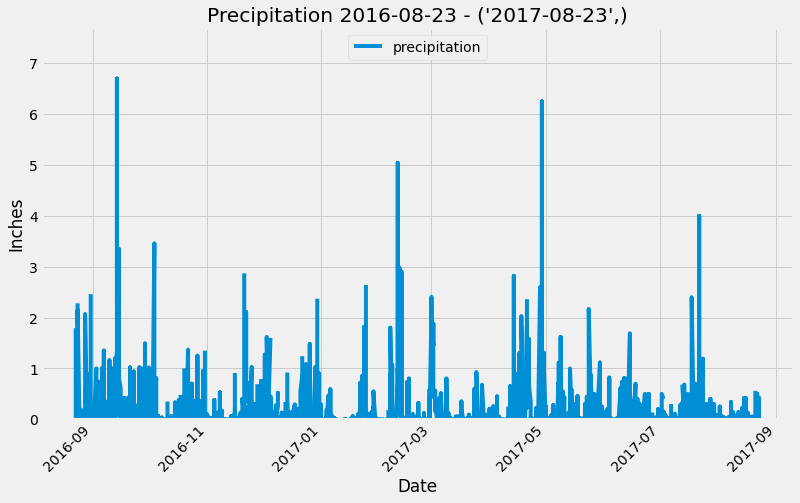

In [27]:
measure_df['date'] = pd.to_datetime(measure_df['date'], format = '%Y-%m-%d')

# Sort the dataframe by date
measure_df = measure_df.set_index('date')
measure_df = measure_df.sort_values(by = ["date"])

# Use Pandas Plotting with Matplotlib to plot the data
measure_df.plot(title = f'Precipitation {year_ago} - {last_data}' , figsize = (12,8), rot = 45)
plt.legend(loc = 'upper center')
plt.ylim(0,7.7)
plt.ylabel('Inches')
plt.xlabel('Date')

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).distinct().count()
stations

9

In [29]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations[0]


('USC00519281', 2772)

In [30]:
# List the stations and the counts in descending order.
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
temp_hi = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp_lo = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(f'The lowest tempt is {temp_lo}, highest is {temp_hi}, and average is {temp_avg}')

The lowest tempt is [(85.0,)], highest is [(54.0,)], and average is [(71.66378066378067,)]


In [33]:
# Choose the station with the highest number of temperature observations.
highest_query = session.query(Measurement.station, func.count(Measurement.prcp)).\
                        group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).first()
highest_query


('USC00519281', 2772)

(0.0, 60.0)

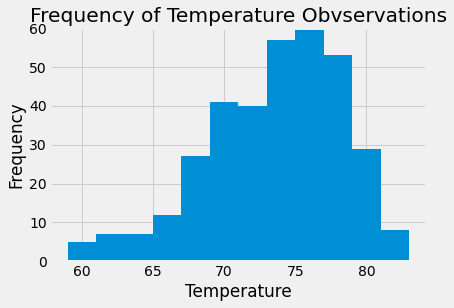

In [71]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= year_ago).\
        filter(Measurement.station == 'USC00519281').all()


temps_df = pd.DataFrame(query)
temps_df.rename(columns={"1":"Temperature"})

temps_df.plot.hist(bins=12, legend=None)
plt.xlabel('Temperature')
plt.title("Frequency of Temperature Obvservations")
plt.ylim(0,60)



## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
